In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05 import *

## Early stopping

### Better callback cancellation

In [3]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(DataLoader(train_ds, bs, shuffle=True),
                 DataLoader(valid_ds, 2 * bs, shuffle=False), c)

In [215]:
#export
class Callback():
    _order = 0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cbname):
        f = getattr(self, cbname, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0.
        self.run.n_iter = 0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1 / self.iters
        self.run.n_iter += 1
        
    def begin_epoch(self):
        self.run.n_epochs = self.epoch
        self.model.train()
        self.run.in_train = True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train = False
        
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [216]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        self.in_train = False
        for cbf in listify(cb_funcs):
            if cbf and cbf():
                cb = cbf()
                setattr(self, cb.name, cb)
                cbs.append(cb)
        self.stop, self.cbs = False, [TrainEvalCallback()] + cbs

    @property
    def opt(self): return self.learn.opt
    @property
    def model(self): return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self): return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb, self.yb = xb, yb
            self('begin_batch')
            self.pred = self.model(xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb, yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs, self.learn = epochs, learn

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cbname):
        res = True
        for cb in sorted(self.cbs, key=lambda x: x._order):
            res = cb(cbname) and res
        return res

In [210]:
learn = create_learner(get_model, loss_func, data)

In [214]:
class TestCallback(Callback):
    _order=0
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10: raise CancelTrainException()

In [217]:
run = Runner(cb_funcs=TestCallback)

In [218]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


### Other callbacks

In [219]:
AvgStats??

In [221]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics, False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.losses = []
        self.lrs = [[] for _ in self.opt.param_groups]

    def after_batch(self):
        if not self.in_train: return
        self.losses.append(self.loss.detach().cpu())
        for lr, pg in zip(self.lrs, self.opt.param_groups): lr.append(pg['lr'])

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order = 1
    def __init__(pname, sched_funcs): self.pname, self.sched_funcs = pname, sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list, tuple)):
            self.sched_funcs = len(self.opt.param_groups) * listify(self.sched_funcs)

    def set_param(self):
        assert len(self.sched_funcs) == len(self.opt.param_groups)
        for sched, pg in zip(self.sched_funcs, self.opt.param_groups):
            pg[self.pname] = sched(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train: self.set_param()

### LR Finder

NB: You may want to also add something that saves the model before running this, and loads it back after running - otherwise you'll lose your weights!

In [229]:
#export
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr*(self.max_lr/self.min_lr)**pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_loss(self):
        if self.n_iter >= self.max_iter or self.loss >= 10 * self.best_loss:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

NB: In fastai we also use exponential smoothing on the loss. For that reason we check for `best_loss*3` instead of `best_loss*10`.

In [230]:
learn = create_learner(get_model, loss_func, data)

In [231]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [232]:
run.fit(2, learn)

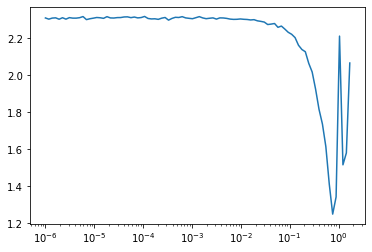

In [233]:
run.recorder.plot(skip_last=5)

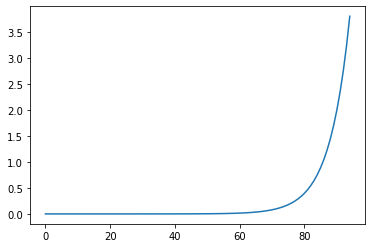

In [234]:
run.recorder.plot_lr()

## Export

In [228]:
#!python notebook2script.py 05b_early_stopping.ipynb